In [7]:
import requests as rq
import time
import urllib.request
from opensea import utils as opensea_utils
import pandas as pd
import numpy as np
import time
import urllib
import os as os
import requests
from opensea import OpenseaAPI
import math
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import manifold
from sklearn import metrics

from scipy.spatial import distance
from scipy.spatial import Delaunay
from scipy.stats import entropy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import networkx as nx

import pickle as pkl

import plotly.express as px

import time
import datetime

# Data Processing Pipeline

We will select 500 (or otherwise the total number of images is <500) images from each of the top 20 generative art collections on the OpenSea platform

In [ ]:
# creating an object to interact with the OpenSea API
API_KEY = "9d3e739e5b9a49f7b2c57878a9ca5c75"
api = OpenseaAPI(apikey=API_KEY)

In [4]:
collection_names = [
    "fidenza-by-tyler-hobbs",
    "ringers-by-dmitri-cherniak",
    "chromie-squiggle-by-snowfro",
    "archetype-by-kjetil-golid",
    "geometry-runners-by-rich-lord-1",
    "phase-by-loren-bednar",
    "skulptuur-by-piter-pasma",
    "pigments-by-darien-brito",
    "deafbeef",
    "autoglyphs",
    "meridian-by-matt-deslauriers",
    "ecumenopolis-by-joshua-bagley",
    "subscapes-by-matt-deslauriers",
    "edifice-by-ben-kovach",
    "avid-lines",
    "rinascita-by-stefano-contiero",
    "singularity-by-hideki-tsukamoto",
    "alien-insects-by-shvembldr",
    "scribbled-boundaries-by-william-tan",
    "the-eternal-pump-by-dmitri-cherniak"
                   ]

collection_dict = {}
contract_address_dict = {}

# grabbing the art work counts for each collection, as well as the contract addresses
for name in collection_names:
    count = api.collection(collection_slug=name)['collection']['stats']['count']
    collection_dict[name] = count
    time.sleep(5) # adding a delay of five seconds per API request
    
    address = api.events(collection_slug = name, # grabbing the contract address correpsonding to the collection
                       limit=10)['asset_events'][0]['asset']['asset_contract']['address']
    contract_address_dict[name] = address
    time.sleep(5)

## Retrieving transaction history

In [97]:
# creating an empty df with columns representing the data that we want to request from the opensea API
sales_df = pd.DataFrame(columns = ['collection', 'token_id', 'date', 'sale_currency', 'currency_price', 'currency_paid', 'usd_equivalent'])

In [85]:
df.head()

,artwork_name,id,collection,contract_address,collection_index
0,alien-insects-500,137000944,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0
1,alien-insects-501,137000949,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0
2,alien-insects-502,137000938,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0
3,alien-insects-503,137000937,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0
4,alien-insects-504,137000957,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0


In [136]:
def collection_transactions(collection, token_ids, sales_df):

    """
    Receives the collection slug and a list of token ids that we want transaction data for, and the sales_df,
    then populates the dataframe with the retrieved information matching the columns in the created df
    """

    for ids in token_ids: #loop through the selection of token IDs that we want transaction data for

        events = api.events(token_id = ids,
                            asset_contract_address = contract_address_dict[collection],
                            collection_slug = collection,
                            event_type='successful')
        time.sleep(10)

        for transaction in events['asset_events']:

            sales_df.loc[len(sales_df)] = [collection, 
                                ids,
                                transaction['created_date'], # creation date
                                transaction['payment_token']['name'], # payment token
                                float(transaction['payment_token']['usd_price']), # payment token price
                                float(transaction['total_price'])/(10**(transaction['payment_token']['decimals'])), # units of payment token paid
                                float(transaction['payment_token']['usd_price']) * float(transaction['total_price'])/(10**(transaction['payment_token']['decimals'])) # usd equivalent
                               ]


        while events['next'] != None: # continue iterating until there are no more batches of transactions left for a given token id

            events = api.events(token_id = ids,
                            asset_contract_address = result['asset_events'][0]['asset']['asset_contract']['address'],
                            collection_slug = collection,
                            occurred_before=period_end,
                            event_type='successful',
                            cursor = events['Next']) # add the cursor to the next page of results
            time.sleep(10) # add a delay so as not to overload API requests

            for transaction in events['asset_events']:

                sales_df.loc[len(sales_df)] = [collection, 
                                    ids, 
                                    transaction['created_date'], # creation date
                                    transaction['payment_token']['name'], # payment token
                                    float(transaction['payment_token']['usd_price']), # payment token price
                                    float(transaction['total_price'])/(10**(transaction['payment_token']['decimals'])), # units of payment token paid
                                    float(transaction['payment_token']['usd_price']) * float(transaction['total_price'])/(10**(result['asset_events'][0]['payment_token']['decimals'])) # usd equivalent
                                   ]
    return sales_df

In [161]:
# for each collection, update the sales_df with all of the transactions registered for that collection
for collection in collection_names:
    print(collection)
    sales_df = collection_transactions(collection, list(df[df.collection == collection].id), sales_df)

scribbled-boundaries-by-william-tan
the-eternal-pump-by-dmitri-cherniak


In [163]:
sales_df

,collection,token_id,date,sale_currency,currency_price,currency_paid,usd_equivalent
0,fidenza-by-tyler-hobbs,78000948,2021-06-11T18:04:39.573210,Ether,3370.81,0.4000,1348.324000
1,fidenza-by-tyler-hobbs,78000948,2021-06-11T16:29:53.517552,Ether,3370.81,0.2749,926.635669
2,fidenza-by-tyler-hobbs,78000947,2021-06-14T22:10:14.220021,Ether,3370.81,0.7800,2629.231800
3,fidenza-by-tyler-hobbs,78000947,2021-06-11T19:05:29.266452,Ether,3370.81,0.2300,775.286300
4,fidenza-by-tyler-hobbs,78000946,2021-10-25T04:26:14.229131,Wrapped Ether,3370.63,175.0000,589860.250000
...,...,...,...,...,...,...,...
10951,the-eternal-pump-by-dmitri-cherniak,22000044,2021-07-26T03:10:32.029832,Ether,3400.38,90.0000,306034.200000
10952,the-eternal-pump-by-dmitri-cherniak,22000042,2021-02-22T23:16:19.567918,Ether,3400.38,25.0000,85009.500000
10953,the-eternal-pump-by-dmitri-cherniak,22000041,2021-08-09T08:05:15.559668,Ether,3400.38,225.0000,765085.500000
10954,the-eternal-pump-by-dmitri-cherniak,22000040,2021-08-14T23:20:36.643877,Ether,3400.38,225.0000,765085.500000


In [45]:
sales_df = pd.read_pickle('sales_dataframe')
sales_df.date = pd.to_datetime(sales_df.date)
sales_df

,collection,token_id,date,sale_currency,currency_price,currency_paid,usd_equivalent
0,fidenza-by-tyler-hobbs,78000948,2021-06-11 18:04:39.573210,Ether,3370.81,0.4000,1348.324000
1,fidenza-by-tyler-hobbs,78000948,2021-06-11 16:29:53.517552,Ether,3370.81,0.2749,926.635669
2,fidenza-by-tyler-hobbs,78000947,2021-06-14 22:10:14.220021,Ether,3370.81,0.7800,2629.231800
3,fidenza-by-tyler-hobbs,78000947,2021-06-11 19:05:29.266452,Ether,3370.81,0.2300,775.286300
4,fidenza-by-tyler-hobbs,78000946,2021-10-25 04:26:14.229131,Wrapped Ether,3370.63,175.0000,589860.250000
...,...,...,...,...,...,...,...
10951,the-eternal-pump-by-dmitri-cherniak,22000044,2021-07-26 03:10:32.029832,Ether,3400.38,90.0000,306034.200000
10952,the-eternal-pump-by-dmitri-cherniak,22000042,2021-02-22 23:16:19.567918,Ether,3400.38,25.0000,85009.500000
10953,the-eternal-pump-by-dmitri-cherniak,22000041,2021-08-09 08:05:15.559668,Ether,3400.38,225.0000,765085.500000
10954,the-eternal-pump-by-dmitri-cherniak,22000040,2021-08-14 23:20:36.643877,Ether,3400.38,225.0000,765085.500000


In [61]:
# filter for non-minting, authentic transactions
sales_df = sales_df[sales_df.usd_equivalent > 70]

168.53650000000002

In [162]:
sales_df.to_pickle('sales_dataframe')

In [29]:
# sales_df = pd.read_pickle('sales_dataframe')

## Retrieving Image Files

The function to download images from a collection in batches is prepared below, after we first prepare a function that saves the uniques IDs of each artwork inside a dictionary

In [55]:
def download_images(collection_slug, collection_size, max_images=500, start_at=0):
    
    """
    Collects 50 images at a time per loop, start_at represents which batch number to begin at so that
    there is no need to start from scratch every time if not necessary.
    
    Returns a list of the artwork token IDs as well as a list of the artwork names
    
    """
    
    # calculate total number of requests needed based on the smaller of the collection size or max number of images
    num_requests = math.ceil( min(max_images,collection_size) /50)
    
    id_list = [] # initialize empty list to populate with NFT token id's
    name_list = [] # initialize empty list to populate with NFT name property
    
    for i in range(start_at, num_requests):
        
        req = api.assets(
            collection = collection_slug,
            offset = i * 50
          )
        
        if req['assets'] != []: # to ensure that the response is correct
        
            print('Request number i =', i)
            
            j = 1
            
            # looping over every single asset contained in the request (50) and saving images
            for asset in req['assets']:
                id_list.append(asset['token_id']) # append the token id of each asset to the id_list variable
                name_list.append(asset['name']) # record the name of the asset
                link = asset['image_url']
                asset_id = str(collection_size - ((i*50) + j))
                r = requests.get(link) # request for the image
                
                # create folder to drop the image files into
                if os.path.exists("../Data/Images/" + collection_slug):
                    pass
                else:
                    os.makedirs("../Data/Images/" + collection_slug)
                j+=1
                
            time.sleep(10)
            print("Last retrieved asset:", asset['name'])
        
        else:
            print ("Response", i, "empty")
            continue
        
    return id_list, name_list

In [56]:
# download the artwork images and ids for each collection
artwork_token_ids = {}
artwork_names = {}
max_images = 500 #we want to save a maximum of 500 images per collection (less if the collection size is smaller)
for collection in collection_names:
    artwork_token_ids[collection], artwork_names[collection] = download_images(collection, collection_dict[collection], 500)

Request number i = 0
Last retrieved asset: Fidenza #949
Request number i = 1
Last retrieved asset: Fidenza #899
Request number i = 2
Last retrieved asset: Fidenza #849
Request number i = 3
Last retrieved asset: Fidenza #800
Request number i = 4
Last retrieved asset: Fidenza #752
Request number i = 5
Last retrieved asset: Fidenza #699
Request number i = 6
Last retrieved asset: Fidenza #649
Request number i = 7
Last retrieved asset: Fidenza #599
Request number i = 8
Last retrieved asset: Fidenza #548
Request number i = 9
Last retrieved asset: Fidenza #500
Request number i = 0
Last retrieved asset: Ringers #950
Request number i = 1
Last retrieved asset: Ringers #900
Request number i = 2
Last retrieved asset: Ringers #850
Request number i = 3
Last retrieved asset: Ringers #802
Request number i = 4
Last retrieved asset: Ringers #750
Request number i = 5
Last retrieved asset: Ringers #700
Request number i = 6
Last retrieved asset: Ringers #650
Request number i = 7
Last retrieved asset: Ringe

Request number i = 3
Last retrieved asset: Avidlines #103678253
Request number i = 4
Last retrieved asset: Avidlines #1349452026
Request number i = 5
Last retrieved asset: Avidlines #3227386046
Request number i = 6
Last retrieved asset: Avidlines #1567031446
Request number i = 7
Last retrieved asset: Avidlines #4058447973
Request number i = 8
Last retrieved asset: Avidlines #3411017778
Request number i = 9
Last retrieved asset: Avidlines #2107965440
Request number i = 0
Last retrieved asset: Rinascita #1058
Request number i = 1
Last retrieved asset: Rinascita #1012
Request number i = 2
Last retrieved asset: Rinascita #961
Request number i = 3
Last retrieved asset: Rinascita #911
Request number i = 4
Last retrieved asset: Rinascita #861
Request number i = 5
Last retrieved asset: Rinascita #811
Request number i = 6
Last retrieved asset: Rinascita #759
Request number i = 7
Last retrieved asset: Rinascita #716
Request number i = 8
Last retrieved asset: Rinascita #662
Request number i = 9
L

# Methods

## Extracting Features

Using a ResNet50 CNN architecture to extract features from the image dataset

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

In [7]:
image_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "../Data/Images/",
    image_size = (224,224),
    labels='inferred',
    label_mode = 'categorical',
    shuffle = False
)

# image_data = image_data.prefetch(buffer_size = 32)

Found 9272 files belonging to 20 classes.


In [6]:
model = ResNet50(weights="imagenet", include_top=False)

In [22]:
features = model.predict(image_data)
features = features.reshape((features.shape[0], 7*7*2048))

In [28]:
np.save('data/features_array', features)

In [89]:
# features_array = np.load('data/features_array.npy')

## Collecting data in dataframe

We now want to create some kind of dataframe that maps together the id, and collection of each image, and the index (that we can then link with the index of the feature vectors)

In [23]:
num_images = len(image_data.file_paths) # getting the total number of images contained

# prepare the list where we save the labels of each point (i.e. where each label is appended)
label_list = []
numerical_list = [] # for the indexes of the label classes
class_names = image_data.class_names

i=0
for image_batch, labels_batch in image_data:
    for labels in labels_batch:
        label_list.append(class_names[sum(np.arange(0,len(class_names))*labels.numpy().astype(int))]) # append the labels of the images to the list
        numerical_list.append(sum(np.arange(0,len(class_names))*labels.numpy().astype(int)))
    i += 1

In [80]:
# string manipulation to get the names, ids and contract addresses of artworks
name_list = [item.split('/')[3].split('by')[0] + item.split('/')[4].split('.')[0] for item in image_data.file_paths]
id_list = [artwork_token_ids[item.split('/')[3]][int(int(item.split('/')[4].split('.')[0]) - collection_dict[item.split('/')[3]] + 50)] for item in image_data.file_paths]
contract_address_list = [contract_address_dict[item.split('/')[3]] for item in image_data.file_paths

In [82]:
df = pd.DataFrame(list(zip(name_list, id_list, label_list, contract_address_list, numerical_list)),
                 columns = ['artwork_name', 'id', 'collection', 'contract_address', 'collection_index'])

9272

In [83]:
df.tail()

,artwork_name,id,collection,contract_address,collection_index
9267,the-eternal-pump-5,22000044,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19
9268,the-eternal-pump-6,22000043,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19
9269,the-eternal-pump-7,22000042,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19
9270,the-eternal-pump-8,22000041,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19
9271,the-eternal-pump-9,22000040,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19


In [84]:
df.to_pickle('artwork_dataframe')
# df = pd.read_pickle('artwork_dataframe')

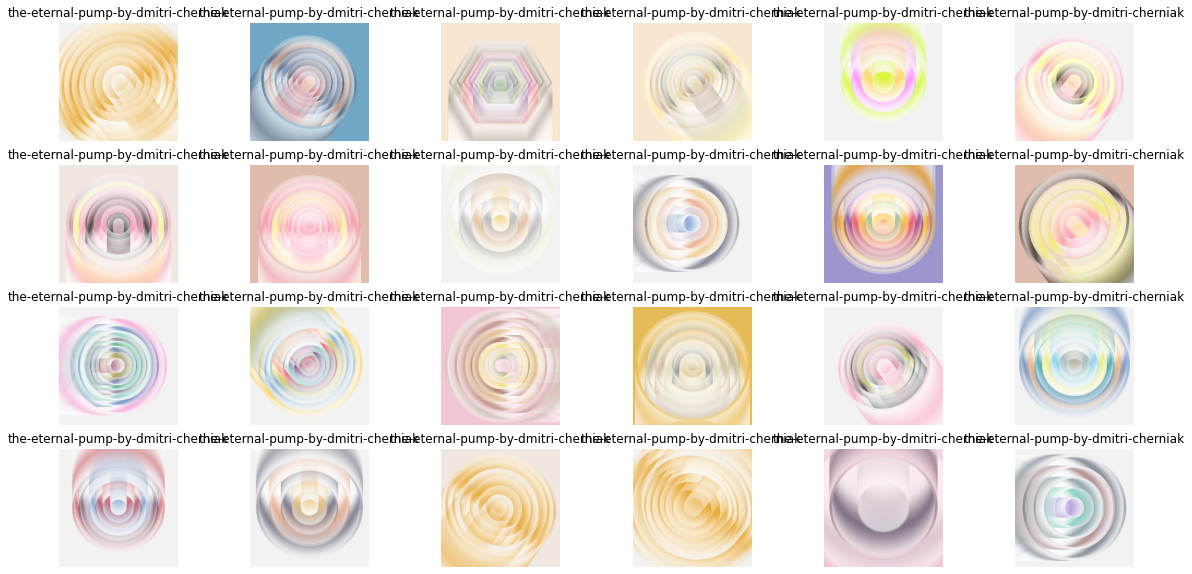

In [32]:
import matplotlib.pyplot as plt
img_fig = plt.figure(figsize = (20, 10))
for i in range(24):
    ax = img_fig.add_subplot(4, 6, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[sum(np.arange(0,len(class_names))*labels_batch[i].numpy().astype(int))])
    plt.axis("off")

## Calculating cosine distances

In [1]:
from tqdm import tqdm_notebook

def create_distance_vector(feature_vector):
    ''' 
    Creates a dense 1-D vector containing the cosine similarity between all points
    '''
    distance_vector = []
    for i in tqdm_notebook(range(0,len(feature_vector))):
        for j in range(0,len(feature_vector)):
            if(i != j):
                if(j > i):
                    distance_vector.append(distance.cosine(feature_vector[i], feature_vector[j]))
    return np.array(distance_vector)

In [238]:
cd_vector = create_distance_vector(features)

<ipython-input-234-fe9743f79637>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0,len(feature_vector))):


In [239]:
np.save('data/top_20_cosine_distance_vector',cd_vector)
# cd_vector = np.load('data/top_20_cosine_distance_vector.npy')

## Performing Hierarchical Clustering

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
linked_cd = linkage(cd_vector.reshape(-1), 'average')

NameError: name 'linkage' is not defined

<ipython-input-256-1b1048185cc4>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


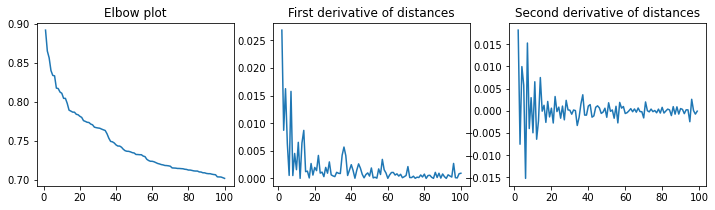

In [256]:
# elbow method shows relationship between threshold distance and number of clusters generated
last = linked_cd[-100:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)

fig, axs = plt.subplots(1, 3, figsize = (12,3))
axs[0].plot(idxs, last_rev)
axs[0].set_title('Elbow plot')
# axs.xlabel('Number of clusters')
# axs.ylabel('Distance between last-joined clusters')

slope = np.diff(last, 1) # first derivative (slope) of distances
slope_rev = slope[::-1]
axs[1].plot(idxs[:-1]+1, slope_rev)
axs[1].set_title('First derivative of distances')

acceleration = np.diff(last, 2) # second derivative of distances
acceleration_rev = acceleration[::-1]
axs[2].plot(idxs[:-2]+1, acceleration_rev)
axs[2].set_title('Second derivative of distances')

fig.show()

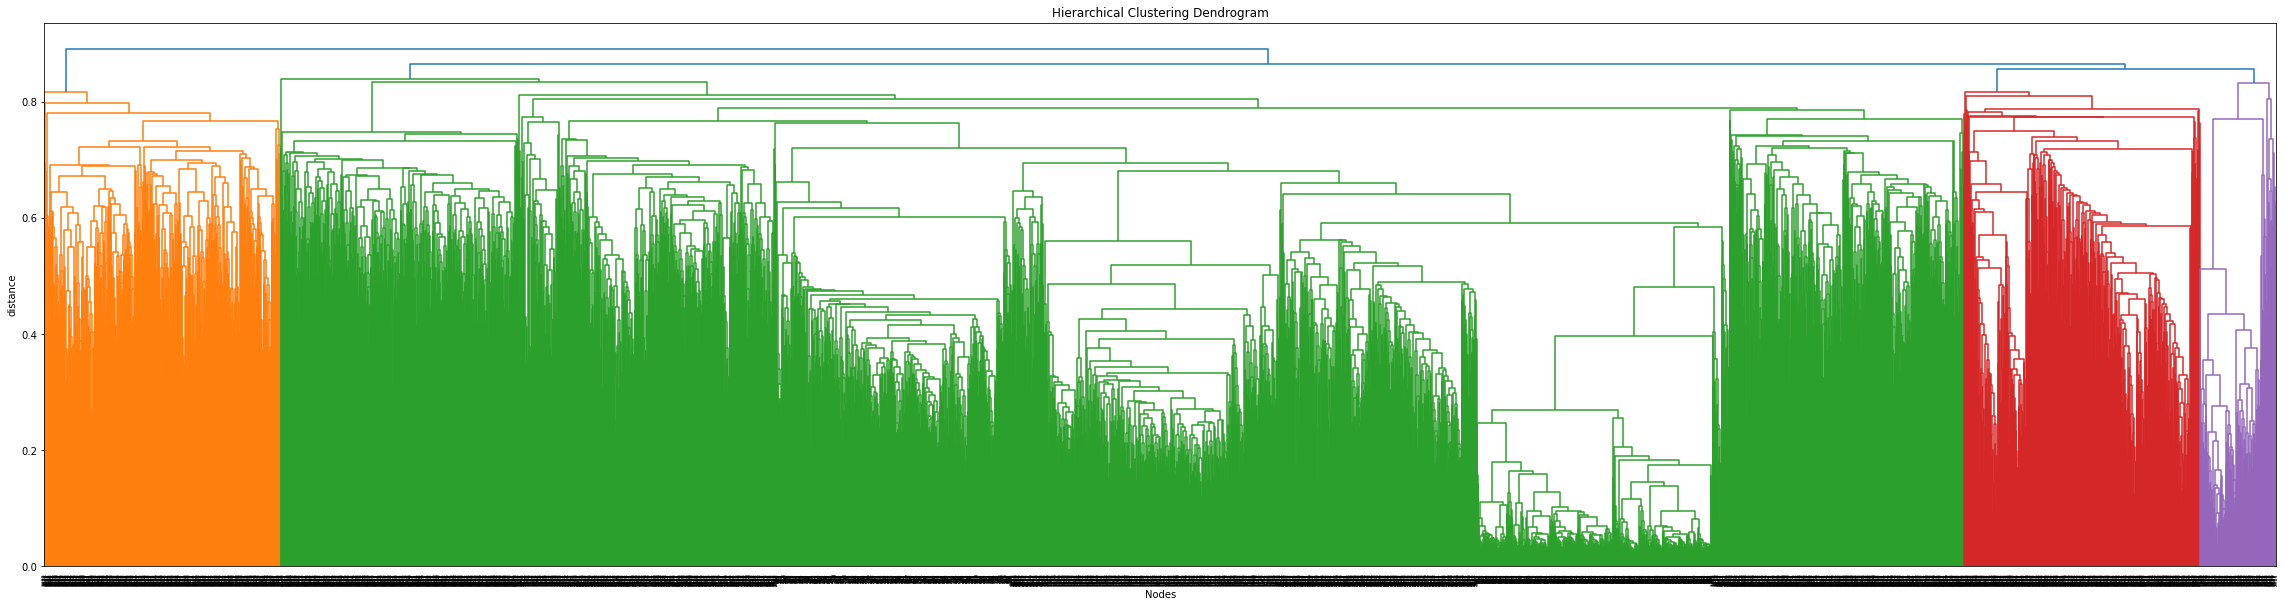

In [259]:
plt.figure(figsize=(40, 10)) 
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Nodes')
plt.ylabel('distance')
dendrogram(linked_cd,
           orientation='top', #The direction to plot the dendrogram
                              #The root at the top, and descendent links going downwards
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_rotation=90,
           leaf_font_size = 5,
           color_threshold = 0.85 # threshold cluster distance at which generated clusters are colored
           )
plt.show()

# Cluster Analytics

## Setup

In [10]:
cd_vector = np.load('data/top_20_cosine_distance_vector.npy') # the full cosine distances of the top 20 collections

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# create the linkage matrix, using average linkage 
linked_cd = linkage(cd_vector.reshape(-1), 'average')

In [11]:
print(cd_vector.shape)
del cd_vector

(42980356,)


## Significant Clusters

Many of the clusters generated by Hierarchical Clustering consist of very small clusters that represent a very small fraction of the overall number of points, therefore we want to focus the analysis on so-called significant clusters, which we define as clusters of size > 20 points

In [16]:
def number_of_significant_clusters(artwork_df, linkage, nclusters, minimum_size):
    """
    calculate number of clusters of size greater than some minimum cutoff_size
    """
    clusters = fcluster(linkage, nclusters, criterion = 'maxclust')
    
    # for each cluster calculate the number of members each class contained within it
    
    sig_clusters = 0
    
    for i in range(0,nclusters):
        grouped = artwork_df.iloc[clusters==i+1].groupby('collection')['collection'].count() # gather all the works with a given cluster label
        if(grouped.sum() > minimum_size):
            sig_clusters += 1   
    
    return sig_clusters

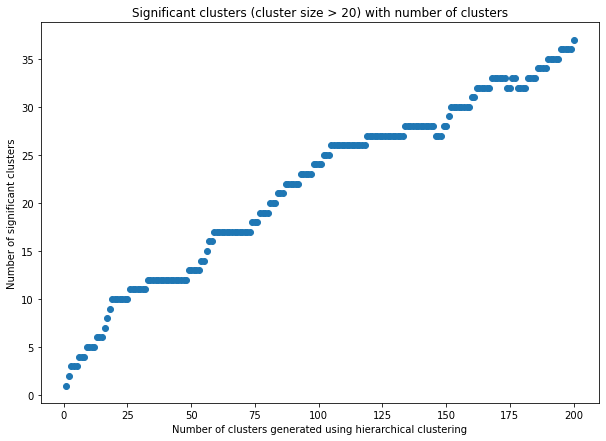

In [19]:
# create a chart of the number of significant clusters with changing numbers of clusters generated by hierarchical clustering

sig_cluster_list = []
for i in range(0,200):
    sig_cluster_list.append(number_of_significant_clusters(df, linked_cd, i+1, 20))
    
fig, ax = plt.subplots(figsize = (10, 7))

x = range(1,201)
y = sig_cluster_list
ax.scatter(x, y)

# ax.set_yscale('log')
# ax.grid(True)
plt.title('Significant clusters (cluster size > 20) with number of clusters')
plt.ylabel('Number of significant clusters')
plt.xlabel('Number of clusters generated using hierarchical clustering')

plt.show()

## Generating breakpoints
Above it's clear that there are certain solutions which produce the same nunber of significant clusters, therefore we will isolate certain 'breakpoints' in cluster number that are the first to produce a certain number of clusters (and therefore ignore the other solutions that produce the same number of significant clusters and are very close to identical)

In [26]:
breakpoints_list = []
for i in range(0,len(set(sig_cluster_list))):
    breakpoint = sig_cluster_list.index(list(set(sig_cluster_list))[i]) + 1
    breakpoints_list.append(breakpoint)

breakpoints_list.sort()
print(breakpoints_list)

[1, 2, 3, 6, 9, 13, 16, 17, 18, 19, 26, 33, 49, 54, 56, 57, 59, 74, 77, 81, 84, 87, 93, 98, 102, 105, 119, 134, 151, 152, 160, 162, 168, 186, 190, 195, 200]


## Silhouette Score

The Silhouette Score and Silhouette Plot are a cluster quality measure that measures the separation distance between clusters. It displays a measure of how close each point in a cluster is to points in the neighbouring clusters.

In [13]:
cd_matrix = np.load('data/top_20_cosine_distance_matrix.npy')
# del cd_matrix

In [14]:
# sklearn.metrics.silhouette_score(X, labels)
clusters= fcluster(linked_cd, 2 , criterion = 'maxclust')

metrics.silhouette_score(cd_matrix, clusters, metric='precomputed')

-0.01826281192546019

In [29]:
sil_score_list = []
for cluster in breakpoints_list[1:]:
    clusters= fcluster(linked_cd, cluster, criterion = 'maxclust')
    sil_score = metrics.silhouette_score(cd_matrix, clusters, metric='precomputed')
    sil_score_list.append(sil_score)

Text(0.5, 1.0, 'Silhouette Score versus Number of Generated Clusters')

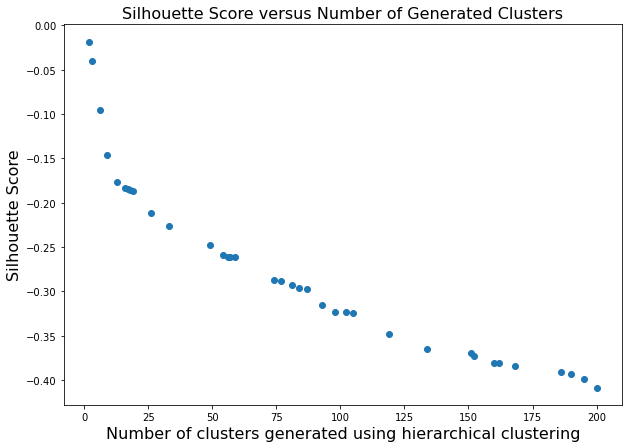

In [37]:
fig,ax=plt.subplots(figsize = (10, 7))

x = breakpoints_list[1:]
y = sil_score_list
ax.scatter(x,y)

# ax.set_yscale('log')

plt.ylabel('Silhouette Score', fontsize=16)
plt.xlabel('Number of clusters generated using hierarchical clustering', fontsize=16)


plt.title('Silhouette Score versus Number of Generated Clusters', fontsize=16)

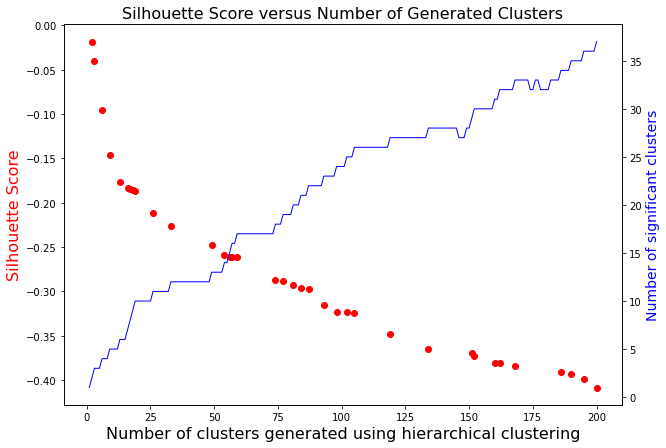

In [34]:
fig,ax=plt.subplots(figsize = (10, 7))

x = breakpoints_list[1:]
y = sil_score_list
ax.scatter(x,y, color='red')

plt.ylabel('Silhouette Score', fontsize=16, color='red')
plt.xlabel('Number of clusters generated using hierarchical clustering', fontsize=16)

plt.title('Silhouette Score versus Number of Generated Clusters', fontsize=16)

ax2=ax.twinx()
ax2.plot(range(1,201), sig_cluster_list[:201],color="blue", linewidth=1)
ax2.set_ylabel("Number of significant clusters",color="blue",fontsize=14)


plt.show()


## Calinski-harabasz score

https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6

The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.

In [182]:
metrics.calinski_harabasz_score(features_array, clusters)

89.48893477841683

In [131]:
ch_score_list = []
for cluster in breakpoints_list[1:]:
    clusters= fcluster(linked_cd, cluster, criterion = 'maxclust')
    ch_score = metrics.calinski_harabasz_score(features_array, clusters)
    ch_score_list.append(ch_score)

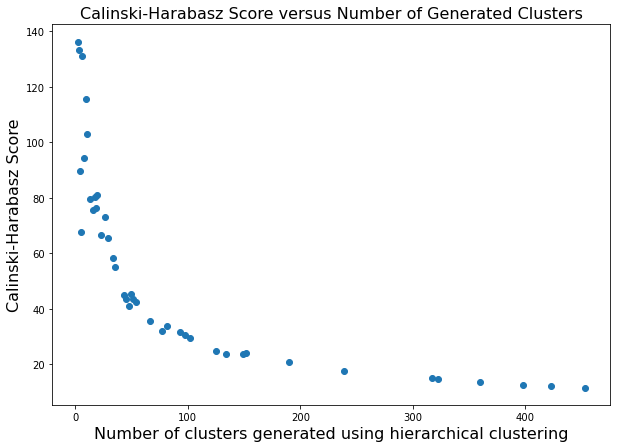

In [132]:
fig,ax=plt.subplots(figsize = (10, 7))

x = breakpoints_list[1:]
y = ch_score_list
ax.scatter(x,y)

# ax.set_yscale('log')

plt.ylabel('Calinski-Harabasz Score', fontsize=16)
plt.xlabel('Number of clusters generated using hierarchical clustering', fontsize=16)


plt.title('Calinski-Harabasz Score versus Number of Generated Clusters', fontsize=16)

plt.show()

## Significant Clusters

In [66]:
def significant_clusters(artwork_df, linkage, nclusters, cutoff=20):
    """
    based on an input dataframe of artworks, a corresponding linkage matrix generated based on
    feature distances, the desired number of clusters to generate, and a cutoff cluster size
    return a list of the clusters, with each item in the list representing a GroupBy object
    containing the number of artworks from each collection for each cluster
    """
    clusters = fcluster(linkage, nclusters, criterion = 'maxclust')
    
    # for each cluster calculate the number of members each class contained within it
    groupby_list = []
    for i in range(0,nclusters):
        if(len(artwork_df.iloc[clusters==i+1]) > cutoff):
            grouped = artwork_df.iloc[clusters==i+1].groupby('collection')['collection'].count()
            groupby_list.append(grouped)
    return groupby_list

In [67]:
# create a dictionary of the significant clusters contained within each breakpoint clustering solution 
significant_cluster_dict = {}

for num in breakpoints_list:
    significant_cluster_dict[num] = significant_clusters(df, linked_cd, num, 20)

In [124]:
significant_cluster_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 8, 9, 10, 13, 16, 17, 18, 19, 23, 26, 29, 33, 35, 43, 45, 48, 49, 51, 54, 66, 77, 81, 93, 97, 102, 125, 134, 149, 152, 190, 239, 317, 322, 360, 398, 423, 453])

In [68]:
significant_cluster_dict[49]

[collection
 pigments-by-darien-brito    479
 Name: collection, dtype: int64,
 collection
 phase-by-loren-bednar    475
 Name: collection, dtype: int64,
 collection
 deafbeef                         71
 rinascita-by-stefano-contiero     1
 Name: collection, dtype: int64,
 collection
 archetype-by-kjetil-golid          1
 ecumenopolis-by-joshua-bagley    410
 edifice-by-ben-kovach              4
 fidenza-by-tyler-hobbs           405
 Name: collection, dtype: int64,
 collection
 edifice-by-ben-kovach     128
 fidenza-by-tyler-hobbs      5
 Name: collection, dtype: int64,
 collection
 ecumenopolis-by-joshua-bagley    43
 Name: collection, dtype: int64,
 collection
 subscapes-by-matt-deslauriers    500
 Name: collection, dtype: int64,
 collection
 alien-insects-by-shvembldr       500
 rinascita-by-stefano-contiero    155
 ringers-by-dmitri-cherniak         3
 Name: collection, dtype: int64,
 collection
 archetype-by-kjetil-golid              499
 autoglyphs                             500


- 

## Normalized Mutual Information

Using a different cluster quality measure that assesses the solution quality by measure of entropy, as opposed to cluster separation

In [112]:
# creating a dictionary containing the indices of the collections
collection_index_dict = {}
i = 0
for collection in collection_names:
    collection_index_dict[collection] = i
    i+=1

In [110]:
def normalized_mutual_info(cluster_list, collection_index_dict):
    """
    Calculates the normalized mutual information score for an input of a list of
    clusters and the number of artworks in each collection contained within, and 
    a dictionary mapping the collection names to an index
    """
    i = 0
    collection_label_list = []
    cluster_id_list = []
    for cluster in cluster_list:
        
        for item in range(0,cluster.sum()):
            cluster_id_list.append(i) # add the cluster label
        
        for collection in cluster.keys():
            for item in range(0,cluster[collection]):
                collection_label_list.append(collection_index_dict[collection]) # add the collection label
        
        i+=1
    # calculate and return the NMI score
    return metrics.cluster.normalized_mutual_info_score(collection_label_list, cluster_id_list)

In [111]:
normalized_mutual_info(significant_cluster_dict[49], collection_index_dict)

0.7284598581916195

In [152]:
# calculating the NMI for each solution 
cluster_solution_nmi_list = []
for solution in significant_cluster_dict.keys():
    cluster_solution_nmi_list.append(normalized_mutual_info(significant_cluster_dict[solution], collection_index_dict))

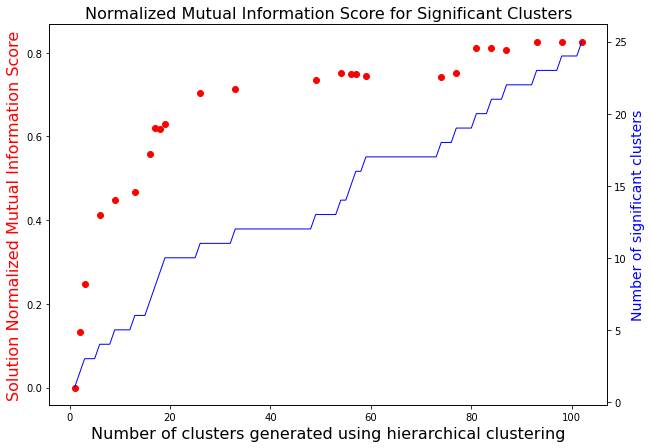

In [153]:
fig,ax=plt.subplots(figsize = (10, 7))

# plot the NMI for each breakpoint solution
x = list(significant_cluster_dict.keys())[:25]
y = cluster_solution_nmi_list[:25]
ax.scatter(x,y, color='red')

plt.ylabel('Solution Normalized Mutual Information Score', fontsize=16, color='red')
plt.xlabel('Number of clusters generated using hierarchical clustering', fontsize=16)
plt.title('Normalized Mutual Information Score for Significant Clusters', fontsize=16)


# make a plot of the number of significant clusters with different y-axis using second axis object
ax2=ax.twinx()
ax2.plot(range(1,103), sig_cluster_list[:102],color="blue", linewidth=1)
ax2.set_ylabel("Number of significant clusters",color="blue",fontsize=14)

plt.show()

In [154]:
significant_cluster_dict.keys()

dict_keys([1, 2, 3, 6, 9, 13, 16, 17, 18, 19, 26, 33, 49, 54, 56, 57, 59, 74, 77, 81, 84, 87, 93, 98, 102, 105, 119, 134, 151, 152, 160, 162, 168, 186, 190, 195])

## Clustering Solution Price/Time Relations

In [71]:
# first we calculate the average collection sales prices (in eth) in the 6 most recent months in the dataset

import datetime as dt
cutoff_date = dt.datetime(2021, 8, 1)

average_price_dict = {}

for collection in collection_names:
    average_price_dict[collection] = sales_df[(sales_df.date>cutoff_date) & (sales_df.sale_currency=="Ether") & (sales_df.collection == collection)].currency_paid.mean()


In [72]:
def cluster_collections_price_scatter(cluster_list, collection_price_dict):
    """
    Takes a list of clusters for a given solution, outputs a scatter plot of the average prices 
    per collection in each cluster
    """
    
    fig,ax=plt.subplots(figsize = (10, 7))
    
    cluster_number = range(1,len(cluster_list)+1)
    
    # plot the average prices of the collections contained within each cluster
    i=0
    for cluster in cluster_list:
        j=0
        for collection in cluster:
            x = cluster_number[i]
            y = collection_price_dict[cluster.keys()[j]]
            s = 30 + 100*math.sin((collection/collection_dict[cluster.keys()[j]]) * math.pi / 2)
            ax.scatter(x, y, label=cluster_number[i], c = cluster_number[i], s=s)
            j+=1
        i+=1
    
    # now plot the average weighted cluster prices in green
    i = 0  
    for cluster in cluster_list:
        x = cluster_number[i]
        
        weighted_price = 0
        j=0
        for collection in cluster:
            weighted_price += (collection / cluster.sum()) * collection_price_dict[cluster.keys()[j]]
            j +=1
        
        y = weighted_price
        
        ax.scatter(x, y, label = cluster_number[i], c = 'green', s=300, alpha=0.3)
        i+=1


    plt.ylabel('Average Price (Eth)', fontsize=16)
    plt.xlabel('Cluster ID', fontsize=16)
    plt.title('Average Artwork Prices Per Collection in Every Significant Cluster', fontsize=16)
    
    fig.show()

<ipython-input-72-d0a6e19c2e5b>:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


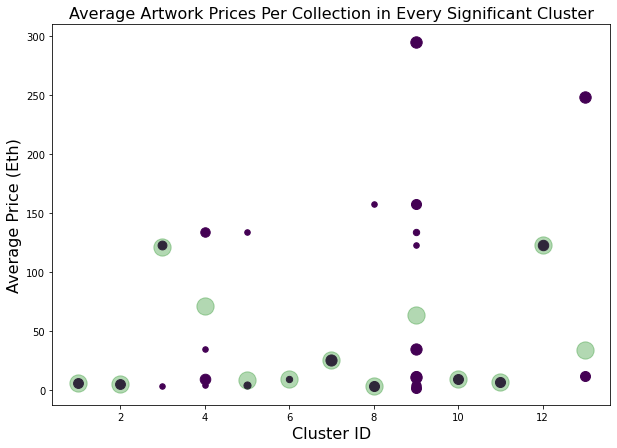

In [73]:
cluster_collections_price_scatter(significant_cluster_dict[49], average_price_dict)

**And now we try to plot the time of release to look for some kind of correlations here**

In [46]:
release_date_dict = {}
for collection in collection_names:
    release_date_dict[collection] = sales_df[sales_df.collection==collection].date.min()

In [62]:
def cluster_collections_release_date_scatter(cluster_list, release_date_dict):
    """
    Takes a list of clusters for a given solution, outputs a scatter plot of the average prices 
    per collection in each cluster, in order of release date
    """
    
    fig,ax=plt.subplots(figsize = (10, 7))
    
    cluster_number = range(1,len(cluster_list)+1)
    
    def get_min(cluster):
        j = 0
        release_date = []
        for collection in cluster:
            release_date.append(release_date_dict[cluster.keys()[j]])
            j+=1
        return min(release_date)
    
    # re-order cluster list according to min_release_date
    cluster_list.sort(key=get_min)
    
    # plot the release dates of the collections contained within each cluster 
    i=0
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#9b1fb4', '#671fb4', '#1f91b4', '#1fb48c']
    for cluster in cluster_list:
        j=0
        for collection in cluster:
            x = cluster_number[i]
            y = release_date_dict[cluster.keys()[j]]
            ax.scatter(x, y, label=cluster_number[i], c = colors[cluster_number[i]], cmap = 'viridis')
            j+=1
        i+=1

    plt.ylabel('Release Date', fontsize=16)
    plt.xlabel('Cluster ID', fontsize=16)
    plt.title('Collection Release Date Per Collection in Every Significant Cluster', fontsize=16)
#     plt.legend()
    
    fig.show()

<ipython-input-62-e5893e3015b1>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


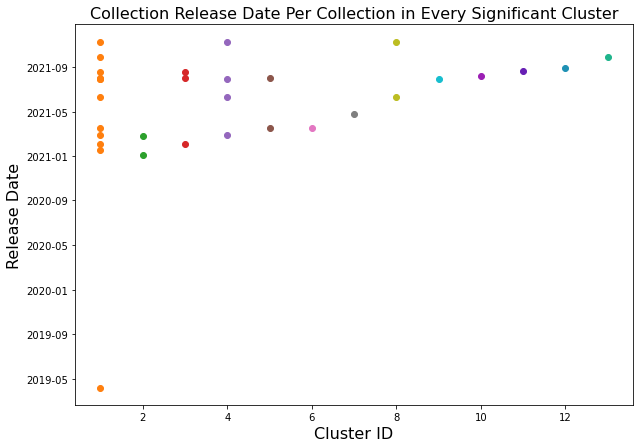

In [63]:
cluster_collections_release_date_scatter(significant_cluster_dict[49], release_date_dict)

# Logistic Regression

## Preparation

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
def get_pca(data, n_components = 5):
    """
    define a function to create a PCA representation of high-dimensional data for a given number of dimensions
    """
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [90]:
features_array = np.load('data/features_array.npy')

output_pca_data = get_pca(features_array, 5) # generate 5-D PCA projection of features

In [91]:
output_pca_data[:,0].shape

(9272,)

Now we augment the artwork dataframe with all the features that we want to use as the basis of our logistic regression

In [92]:
del features_array
df = pd.read_pickle('artwork_dataframe')

In [93]:
# add the 5-dimensional PCA outputs to the df
cols = ['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5']
i = 0
for col in cols:
    df[col] = output_pca_data[:,i]
    i += 1

In [94]:
# adding a column for the release date of the collection
df['release_date'] = df.collection.apply(lambda x: release_date_dict[x])

In [95]:
# assigning the clusters to each artwork
num_clusters = 49 # total number of clusters to generate, including non-significant clusters

df['assigned_cluster'] = fcluster(linked_cd, num_clusters, criterion='maxclust')

# filtering the df based on points assigned to significant clusters
df_significant = df[df['assigned_cluster'].isin(list((df['assigned_cluster'].value_counts()>20)[(df['assigned_cluster'].value_counts()>20)==True].keys()))]
df_significant

,artwork_name,id,collection,contract_address,collection_index,pca_1,pca_2,pca_3,pca_4,pca_5,release_date,assigned_cluster
0,alien-insects-500,137000944,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0,83.706650,-61.723999,215.513901,-64.681694,15.258553,2021-08-18 18:38:38.271636,40
1,alien-insects-501,137000949,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0,59.637741,-3.981480,189.902206,-41.413338,39.283642,2021-08-18 18:38:38.271636,40
2,alien-insects-502,137000938,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0,78.968475,-24.787924,120.816147,-9.808698,30.335983,2021-08-18 18:38:38.271636,40
3,alien-insects-503,137000937,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0,84.603157,-22.401579,220.886856,-57.022446,17.415852,2021-08-18 18:38:38.271636,40
4,alien-insects-504,137000957,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0,60.226593,-36.619915,169.116196,-3.010307,11.628860,2021-08-18 18:38:38.271636,40
...,...,...,...,...,...,...,...,...,...,...,...,...
9267,the-eternal-pump-5,22000044,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19,64.699005,37.362049,-54.742966,-38.740051,-31.397387,2021-02-22 20:24:47.606649,49
9268,the-eternal-pump-6,22000043,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19,89.278008,18.886791,-32.549965,-56.148586,-51.908714,2021-02-22 20:24:47.606649,49
9269,the-eternal-pump-7,22000042,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19,26.478802,-13.207893,-69.325417,-36.541035,-49.276699,2021-02-22 20:24:47.606649,49
9270,the-eternal-pump-8,22000041,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19,19.360342,1.130505,-49.991425,-7.455442,-31.346407,2021-02-22 20:24:47.606649,49


Now we try to integrate the latest sales data of artworks in the last 6 months

In [100]:
# make a df with each token id, as well as the most recent sale
token_id = pd.Series(list(sales_df[(sales_df.date>cutoff_date) & (sales_df.sale_currency == 'Ether')].token_id.value_counts().index))

175.0

In [101]:
latest_sales_df = pd.DataFrame(token_id, columns = ['id'])
latest_sales_df['latest_sale'] = latest_sales_df['id'].apply(lambda x: sales_df[sales_df.token_id == x].currency_paid.max())
latest_sales_df = latest_sales_df[latest_sales_df.id != '0'] # remove spurious entries
latest_sales_df

,id,latest_sale
1,138000587,12.00
2,131000985,6.00
3,143000998,18.00
4,129000569,13.40
5,121000794,3.75
...,...,...
4350,78000579,49.88
4351,143000844,3.88
4352,137000917,2.59
4353,163000543,20.00


Now we merge the dataframe of sales prices with the entries of the features df that have registered sales in the last 6 months

In [102]:
df_significant['copy_index'] = df_significant.index
complete_df = pd.merge(df_significant, latest_sales_df).set_index('copy_index') # merge, and keep the indices of the original artwork df
complete_df['release_date'] = complete_df['release_date'].apply(lambda x: x.timestamp())
complete_df

<ipython-input-102-f759df7093dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['copy_index'] = df_significant.index


,artwork_name,id,collection,contract_address,collection_index,pca_1,pca_2,pca_3,pca_4,pca_5,release_date,assigned_cluster,latest_sale
copy_index,,,,,,,,,,,,,
0,alien-insects-500,137000944,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0,83.706650,-61.723999,215.513901,-64.681694,15.258553,1.629312e+09,40,5.25
1,alien-insects-501,137000949,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0,59.637741,-3.981480,189.902206,-41.413338,39.283642,1.629312e+09,40,6.90
2,alien-insects-502,137000938,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0,78.968475,-24.787924,120.816147,-9.808698,30.335983,1.629312e+09,40,2.85
3,alien-insects-503,137000937,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0,84.603157,-22.401579,220.886856,-57.022446,17.415852,1.629312e+09,40,4.00
4,alien-insects-504,137000957,alien-insects-by-shvembldr,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,0,60.226593,-36.619915,169.116196,-3.010307,11.628860,1.629312e+09,40,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9252,the-eternal-pump-36,22000009,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19,43.555031,38.441601,-45.692226,-85.948776,-64.441330,1.614025e+09,49,320.00
9255,the-eternal-pump-39,22000011,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19,86.047447,23.762918,-35.176651,-35.329025,-38.695477,1.614025e+09,49,450.00
9260,the-eternal-pump-43,22000005,the-eternal-pump-by-dmitri-cherniak,0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270,19,90.450287,77.004280,-55.437202,-63.510555,-36.507717,1.614025e+09,49,150.00


In [103]:
complete_df.collection.value_counts()

scribbled-boundaries-by-william-tan    429
edifice-by-ben-kovach                  429
phase-by-loren-bednar                  428
meridian-by-matt-deslauriers           413
skulptuur-by-piter-pasma               398
rinascita-by-stefano-contiero          356
pigments-by-darien-brito               352
geometry-runners-by-rich-lord-1        311
ecumenopolis-by-joshua-bagley          223
avid-lines                             204
alien-insects-by-shvembldr             167
archetype-by-kjetil-golid              110
fidenza-by-tyler-hobbs                  98
subscapes-by-matt-deslauriers           89
chromie-squiggle-by-snowfro             83
singularity-by-hideki-tsukamoto         76
ringers-by-dmitri-cherniak              61
autoglyphs                              33
deafbeef                                20
the-eternal-pump-by-dmitri-cherniak      8
Name: collection, dtype: int64

## Building and testing the model

In [163]:
# x = the inputs
x = complete_df[['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'release_date', 'latest_sale']]

# y = the ground truth cluster labels
y = complete_df['assigned_cluster']

In [164]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [165]:
# standardize the inputs
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

In [166]:
model = LogisticRegression(solver='liblinear', C=0.05, multi_class='ovr',
                           random_state=0)
model.fit(x_train, y_train)

LogisticRegression(C=0.05, multi_class='ovr', random_state=0,
                   solver='liblinear')

In [167]:
model.score(x_train, y_train)

0.8559766763848397

In [168]:
x_test = scaler.transform(x_test)
y_pred = model.predict(x_test)

In [169]:
model.score(x_test, y_test)

0.8682983682983683

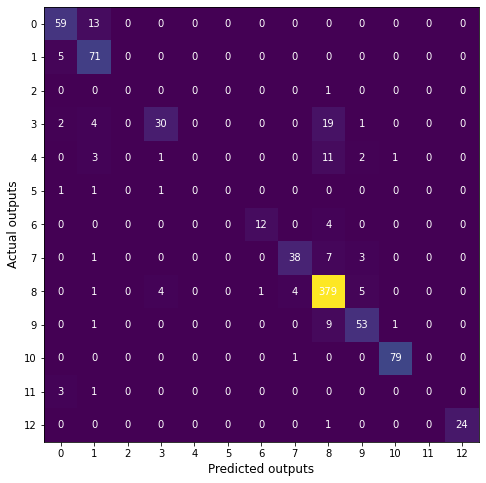

In [170]:
cm = confusion_matrix(y_test, y_pred)

font_size = 12

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=font_size, color='black')
ax.set_ylabel('Actual outputs', fontsize=font_size, color='black')
ax.xaxis.set(ticks=range(13))
ax.yaxis.set(ticks=range(13))
ax.set_ylim(12.5, -0.5)
for i in range(13):
    for j in range(13):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

In [112]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.84      0.82      0.83        72
          10       0.74      0.93      0.83        76
          29       0.00      0.00      0.00         1
          31       0.83      0.54      0.65        56
          32       0.00      0.00      0.00        18
          35       0.00      0.00      0.00         3
          39       0.92      0.75      0.83        16
          40       0.88      0.78      0.83        49
          41       0.88      0.96      0.92       394
          43       0.83      0.83      0.83        64
          46       0.98      0.99      0.98        80
          47       0.00      0.00      0.00         4
          49       1.00      0.96      0.98        25

    accuracy                           0.87       858
   macro avg       0.61      0.58      0.59       858
weighted avg       0.84      0.87      0.85       858



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature: 0, Score: 0.06106
Feature: 1, Score: -1.50819
Feature: 2, Score: -0.93836
Feature: 3, Score: 0.13067
Feature: 4, Score: -0.60987
Feature: 5, Score: -0.24479
Feature: 6, Score: -0.04584


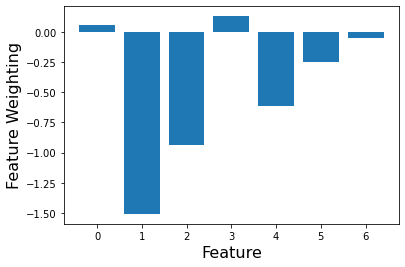

In [175]:
from matplotlib import pyplot
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('Feature Weighting', fontsize = 16)
plt.show()